In [1]:
## Setup
import numpy as np
import matplotlib.pyplot as plt

import os, sys, pickle

## Setup

In [2]:
# System and devices
from devices.device import Transmon, Resonator
from devices.system import (
    dispersive_shift,
    QubitResonatorSystem,
)

coupling_strength = 0.25 * 2 * np.pi

qubit = Transmon(
    EC=15 / 100 * 2 * np.pi,
    EJ=15 * 2 * np.pi,
    n_cutoff=15,
    levels=4,
    ng=0.0,
    T1=0,
)

resonator = Resonator(
    frequency=6.00, levels=10, kappa=1 / 10
)

In [3]:
# Pulses 
from devices.pulses import SquareCosinePulse, CloakedPulse_with_x_pulse

resonator_pulse = SquareCosinePulse(
    amplitude=0.15,
    frequency=6.045,
    phase=-np.pi / 2,
    duration=100,
    start_time=0,
)

omega_minus = 2 * np.pi * (resonator.frequency - resonator_pulse.frequency)

amplitude = (
    -coupling_strength
    * resonator_pulse.amplitude
    / np.sqrt(omega_minus**2 + resonator.kappa**2 / 4)
)
phase = np.arctan(-2 * omega_minus / resonator.kappa)

qubit_pulse_w_x = CloakedPulse_with_x_pulse(
    frequency=resonator_pulse.frequency,
    resonator_frequency=resonator.frequency,
    amplitude=amplitude,
    duration=100,
    start_time=0,
    kappa=resonator.kappa,
    phase=phase,
    x_frequency=4.024677286666339,
    x_duration=16,
    x_ampltiude=np.pi / 16 / 1.305,
)

## Pulse Investigation

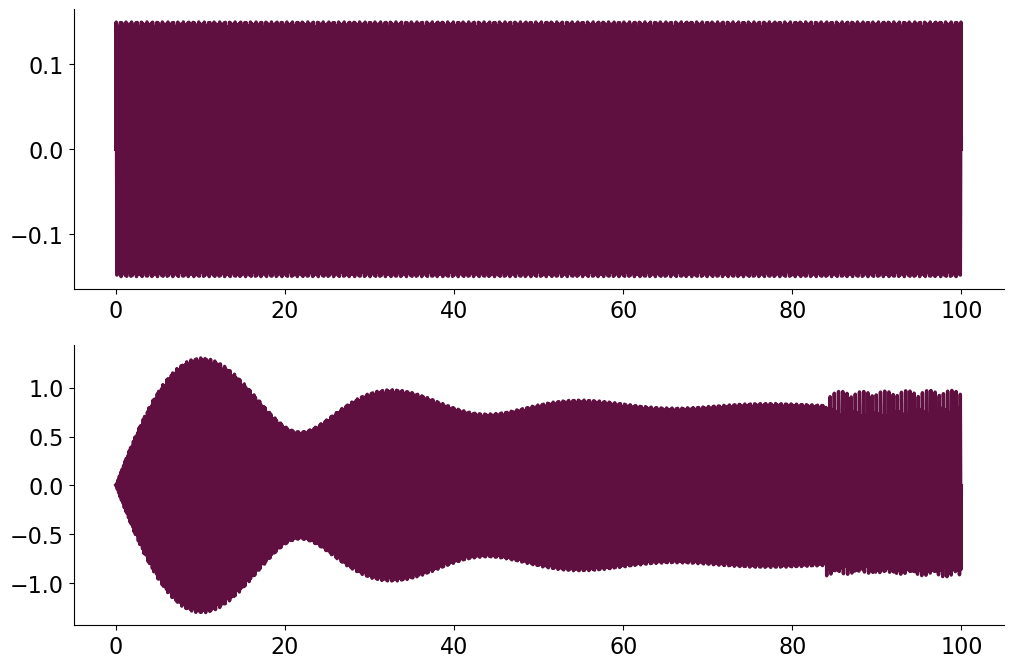

In [9]:
fig, ax = plt.subplots(nrows = 2)
times = np.linspace(0, 100, 5000)
pulse_shape_reso = [resonator_pulse.pulse(t, None) for t in times]
pulse_shape_cloak = [qubit_pulse_w_x.pulse(t, None) for t in times]
ax[0].plot(times, pulse_shape_reso, label="Resonator pulse")

ax[1].plot(times, pulse_shape_cloak, label="Cloaking pulse")


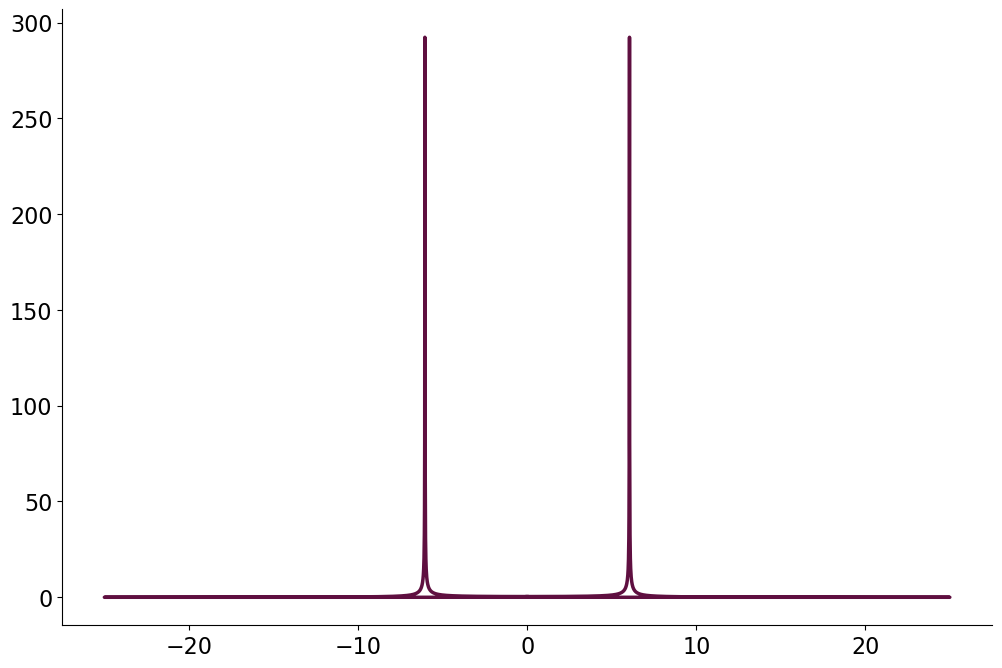

In [19]:
from numpy.fft import fft, fftfreq

freqs = fftfreq(len(times), times[1] - times[0])
fft_reso = fft(pulse_shape_reso)

plt.plot(freqs, np.abs(fft_reso), label="Resonator pulse")

(3.0, 7.0)

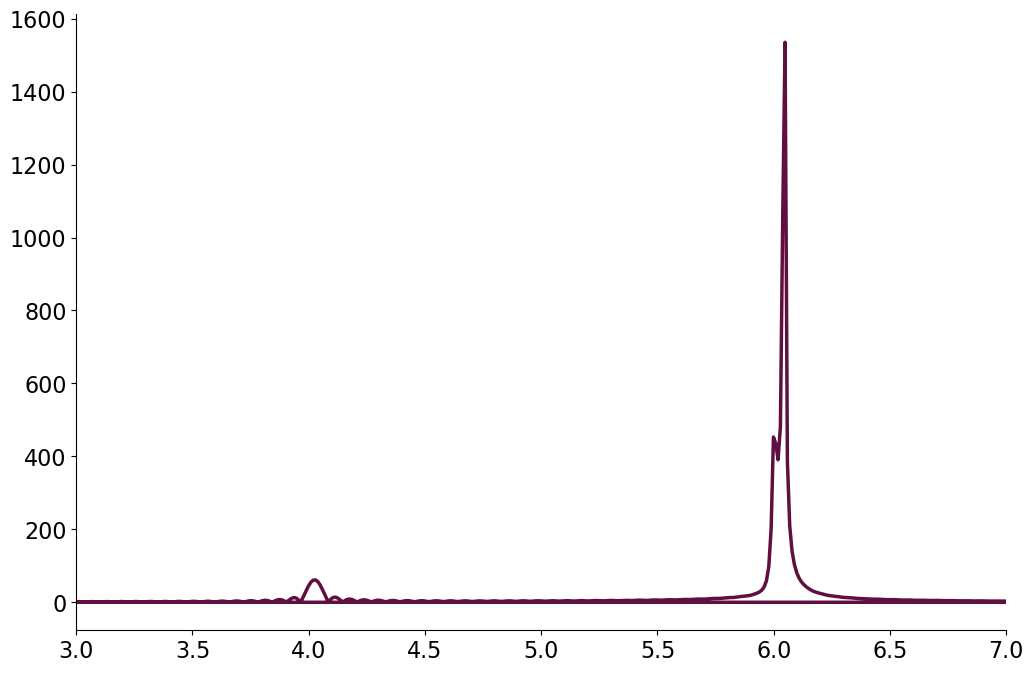

In [23]:
from numpy.fft import fft, fftfreq

freqs = fftfreq(len(times), times[1] - times[0])
fft_cloak = fft(pulse_shape_cloak)

plt.plot(freqs, np.abs(fft_cloak), label="Resonator pulse")

plt.xlim(3, 7)

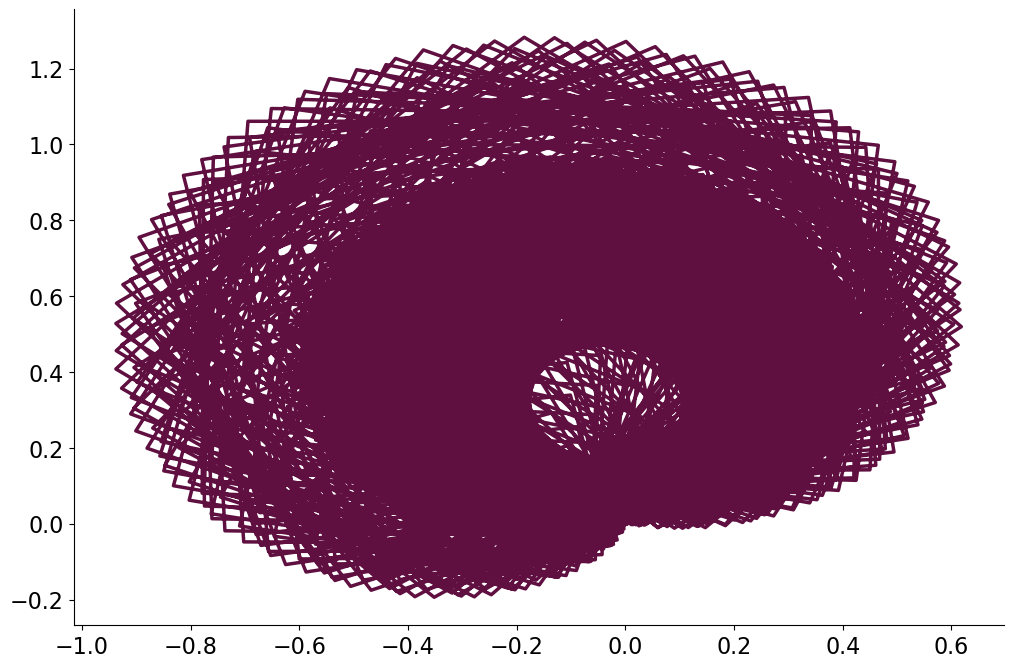

In [16]:
# demodulate
rotation_frequency = 2 * np.pi * resonator_pulse.frequency 
alphas = np.exp(- 1j * rotation_frequency * times)

demodded = alphas * np.array(pulse_shape_cloak)

plt.plot(demodded.real, demodded.imag, label="Demodulated")

In [4]:
## Define System
system = QubitResonatorSystem(
    qubit=qubit,
    resonator=resonator,
    qubit_pulse=qubit_pulse_w_x,
    resonator_pulse=resonator_pulse,
    coupling_strength=coupling_strength,
)

In [5]:
from simulation.experiment import MonteCarloExperiment, LindbladExperiment

times = np.linspace(0, 100, 500) # ns

experiment = MonteCarloExperiment(
    system=system,
    states=[system.get_states(0, 0)],
    times=times,
    store_states=False,
    only_store_final=False,
    expectation_operators=[
        system.photon_number_operator(),
        system.qubit_state_occupation_operator(1),
    ],
    ntraj=5,
    exp_val_method="average",
)

results = experiment.run()


plotting time evolution


(<Figure size 1200x800 with 2 Axes>,
 array([[<AxesSubplot:title={'center':'State 0'}, ylabel='exp_val'>],
        [<AxesSubplot:xlabel='time', ylabel='exp_val'>]], dtype=object))

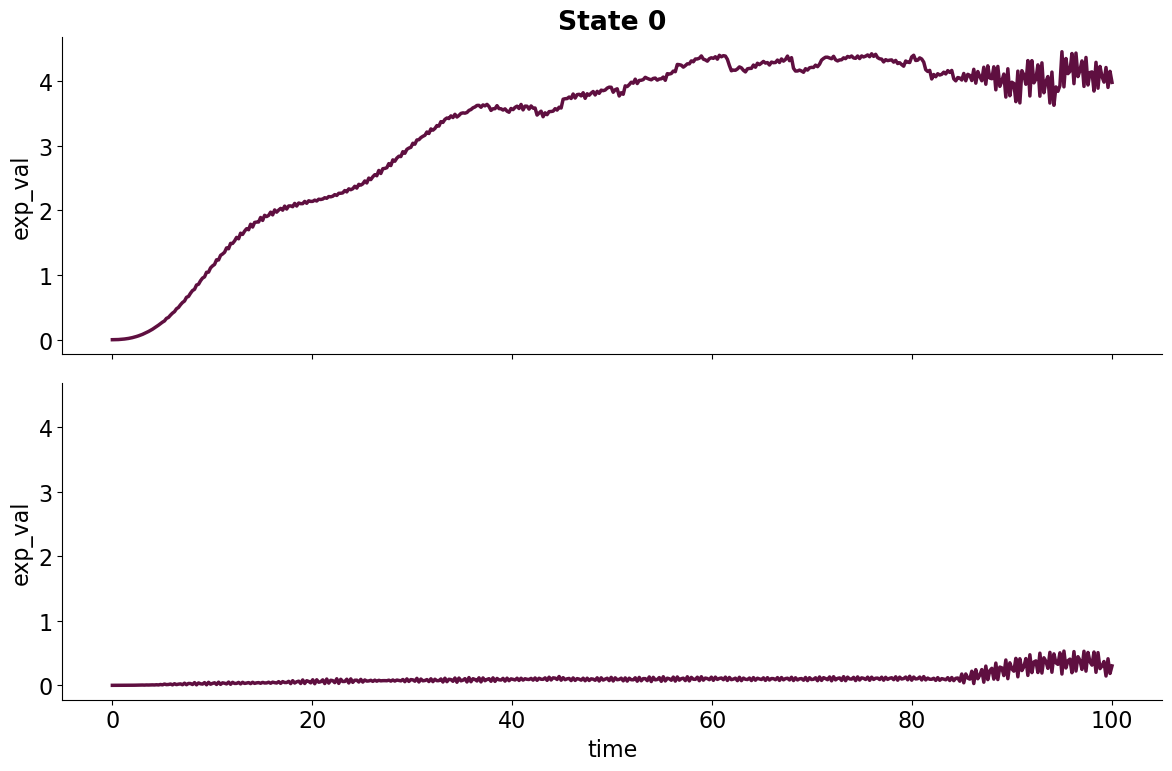

In [6]:
from analysis.auto import automatic_analysis

automatic_analysis(results)

NameError: name 'mnt' is not defined